## 1. Data Prep
Reference:https://pypi.org/project/yahoofinancials/
https://stackoverflow.com/questions/49705047/downloading-mutliple-stocks-at-once-from-yahoo-finance-python

In [22]:
# Setup
#! pip install yfinance
# import yfinance as yf
#! pip install yahoofinancials
import yahoofinancials
from yahoofinancials import YahooFinancials

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import itertools
import pandas as pd
import numpy as np

#import socket
#socket.getaddrinfo('localhost', 8080)

In [25]:
# Select tickers and stock history dates
ticker = ['SNP']
#,'NDAQ','DJI']
    
#'ADM','BGS','BG','CPB','CAG','CZZ','DAR','FLO',
#'GIS','HSY','INGR','SJM','K','MKC','MED', 
#'POST','TR','THS'
#Unavailable stock data: 'ANFI','DF','GMK','MUN','OME','PF','WWAV'

freq = 'daily' # 'daily' works
start_date = '2019-12-01' 
end_date = '2021-07-21'

In [26]:
# Download data: construct yahoo financials objects for data extraction
yahoo_financials = YahooFinancials(ticker)
historical_stock_prices = yahoo_financials.get_historical_price_data(start_date, end_date, freq)

OSError: [Errno socket error] [Errno 11001] getaddrinfo failed

In [27]:
# Read into Dataframe with multi-index
df = pd.DataFrame.from_dict({(i,j,k): historical_stock_prices[i]['prices'][j][k]
                                for i in historical_stock_prices.keys()
                                for j in (list(range(98)))
                                for k in ['formatted_date','adjclose']},
                            orient = 'index',
                           columns = ['value'])
df

NameError: name 'historical_stock_prices' is not defined

In [30]:
# Flattern the multi-index
index = pd.MultiIndex.from_tuples(df.index)
df_2 = df.reindex(index).reset_index()
df_2["level_00"] = df_2["level_0"] + df_2["level_1"].astype(str)
df_2

,level_0,level_1,level_2,value,level_00
0,SNP,0,formatted_date,2019-12-02,SNP0
1,SNP,0,adjclose,51.6007,SNP0
2,SNP,1,formatted_date,2019-12-03,SNP1
3,SNP,1,adjclose,50.7358,SNP1
4,SNP,2,formatted_date,2019-12-04,SNP2
...,...,...,...,...,...
583,DJI,95,adjclose,24575.9,DJI95
584,DJI,96,formatted_date,2020-05-21,DJI96
585,DJI,96,adjclose,24474.1,DJI96
586,DJI,97,formatted_date,2020-05-22,DJI97


In [31]:
# From long to wide - formatted_date and adjclose
df_3 = df_2.pivot(index='level_00', columns='level_2', values='value')

In [32]:
# Generate 'ticker name' and prep for pivot
df_3['ticker name'] = df_3.index.str.replace('\d+', '')
df_3

level_2,adjclose,formatted_date,ticker name
level_00,,,
DJI0,28634.9,2020-01-03,DJI
DJI1,28703.4,2020-01-06,DJI
DJI10,29348.1,2020-01-17,DJI
DJI11,29196,2020-01-21,DJI
DJI12,29186.3,2020-01-22,DJI
...,...,...,...
SNP93,45.4358,2020-04-16,SNP
SNP94,46.2271,2020-04-17,SNP
SNP95,45.2886,2020-04-20,SNP


In [33]:
# From long to wide - ticker name
df_4 = df_3.pivot(index='formatted_date', columns='ticker name',values='adjclose')
df_4

ticker name,DJI,NDAQ,SNP
formatted_date,,,
2019-12-02,NaN,101.946,51.6007
2019-12-03,NaN,101.966,50.7358
2019-12-04,NaN,102.678,51.2878
2019-12-05,NaN,102.151,50.9198
2019-12-06,NaN,102.698,51.2786
...,...,...,...
2020-05-18,24597.4,NaN,NaN
2020-05-19,24206.9,NaN,NaN
2020-05-20,24575.9,NaN,NaN


In [34]:
# Final rearrange
df_4 = df_4.reset_index()
del df_4.columns.name
df_4

,formatted_date,DJI,NDAQ,SNP
0,2019-12-02,NaN,101.946,51.6007
1,2019-12-03,NaN,101.966,50.7358
2,2019-12-04,NaN,102.678,51.2878
3,2019-12-05,NaN,102.151,50.9198
4,2019-12-06,NaN,102.698,51.2786
...,...,...,...,...
115,2020-05-18,24597.4,NaN,NaN
116,2020-05-19,24206.9,NaN,NaN
117,2020-05-20,24575.9,NaN,NaN
118,2020-05-21,24474.1,NaN,NaN


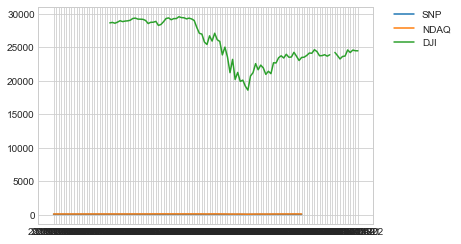

In [35]:
# Draw plot of daily stock price for each single stock
x = df_4['formatted_date']
plot = plt.plot(x, df_4[ticker])
plt.legend(plot, ticker, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [36]:
# Calculate daily return of each single stock
df_5 = df_4[ticker].pct_change()
df_5['formatted_date'] = df_4['formatted_date']
df_5

,SNP,NDAQ,DJI,formatted_date
0,NaN,NaN,NaN,2019-12-02
1,-0.016762,0.000192,NaN,2019-12-03
2,0.010881,0.006987,NaN,2019-12-04
3,-0.007176,-0.005133,NaN,2019-12-05
4,0.007047,0.005350,NaN,2019-12-06
...,...,...,...,...
115,0.000000,0.000000,0.038505,2020-05-18
116,0.000000,0.000000,-0.015876,2020-05-19
117,0.000000,0.000000,0.015244,2020-05-20
118,0.000000,0.000000,-0.004142,2020-05-21


In [44]:
df_5.to_csv('YahooFinanceStock_timeseries.csv')

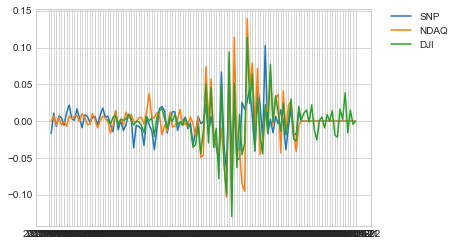

In [37]:
# Draw plot of daily return for each single stock price
x = df_5['formatted_date']
plot_return = plt.plot(x, df_5[ticker])
plt.legend(plot_return, ticker, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

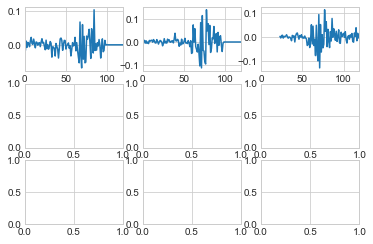

In [42]:
# Draw subplots (daily return) separately to see clearly
fig, axes = plt.subplots(nrows=3, ncols=3)

for (t, (i, j)) in zip(list(range(3)), itertools.product(range(3), range(3))):
    df_5[ticker[t]].plot(ax=axes[i,j], label=ticker[t])

In [43]:
# Correlation across portfolio
cov_matrix = df_5.cov()
cov_matrix

,SNP,NDAQ,DJI
SNP,0.000505,0.000341,0.000521
NDAQ,0.000341,0.001159,0.001063
DJI,0.000521,0.001063,0.001142


## 2. Time Series Analysis

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#! pip install arch --no-binary arch
from arch import arch_model

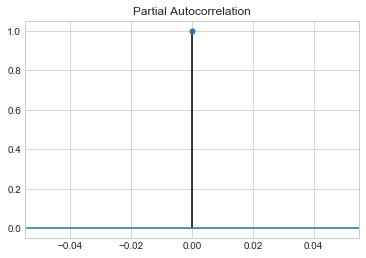

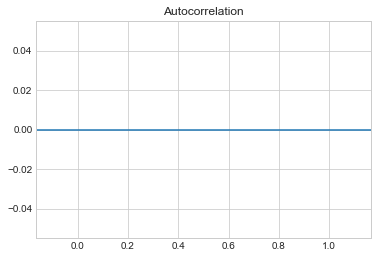

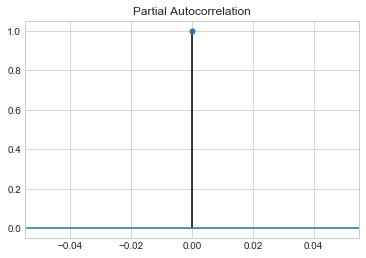

In [26]:
temp = df_5[['formatted_date','SNP']].set_index('formatted_date').drop(['2020-01-02'])
temp

# create acf and pacf plots
plot_acf(temp.values.squeeze(), lags=30);
plot_pacf(temp.values.squeeze(), lags=30)

In [19]:
# split into train/test
n_test = 15
train, test = temp[:-n_test], temp[-n_test:]

In [20]:
# define model - ARCH Model
model = arch_model(train, mean='Zero', vol='ARCH', p=15)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon=n_test)

Iteration:      1,   Func. Count:     35,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 35
            Gradient evaluations: 2


C:\Users\cjane\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


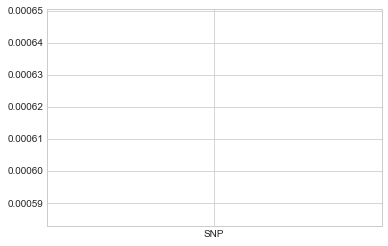

In [21]:
# plot the actual variance
var = np.var(temp)

plt.plot(var)
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])

Resources:
https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/
https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html
https://www.interviewqs.com/blog/value_at_risk

In [38]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

In [39]:
#ticker = ['SNP','NDAQ','DJI']
    
ticker_df = yf.download('SNP', 
                        start='2019-12-01', 
                        end='2021-6-01', 
                        interval = '1h',
                        progress=False)
ticker_df.head(100)
#ticker_df.to_csv('YahooFinanceStock_hourly.csv')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-02,56.000000,56.340000,56.000000,56.119999,56.119999,0
2019-12-02,56.110001,56.230000,56.080002,56.230000,56.230000,16431
2019-12-02,56.189999,56.290001,56.130001,56.189999,56.189999,23380
2019-12-02,56.205002,56.270000,56.174999,56.250198,56.250198,11268
2019-12-02,56.247501,56.259998,56.141899,56.168098,56.168098,11809
...,...,...,...,...,...,...
2019-12-19,58.500000,58.500000,58.410000,58.414001,58.414001,14372
2019-12-19,58.439999,58.470001,58.360001,58.380001,58.380001,15566
2019-12-19,58.380001,58.500000,58.380001,58.500000,58.500000,16957


In [40]:
ticker_df = ticker_df.reset_index()
del ticker_df.columns.name
ticker_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-02,56.000000,56.340000,56.000000,56.119999,56.119999,0
1,2019-12-02,56.110001,56.230000,56.080002,56.230000,56.230000,16431
2,2019-12-02,56.189999,56.290001,56.130001,56.189999,56.189999,23380
3,2019-12-02,56.205002,56.270000,56.174999,56.250198,56.250198,11268
4,2019-12-02,56.247501,56.259998,56.141899,56.168098,56.168098,11809
...,...,...,...,...,...,...,...
2618,2021-05-28,54.084999,54.084999,53.950001,54.049900,54.049900,18520
2619,2021-05-28,54.009998,54.080002,54.000000,54.049999,54.049999,5198
2620,2021-05-28,54.110001,54.139999,54.000000,54.070000,54.070000,5837
2621,2021-05-28,54.089298,54.090000,53.959999,53.959999,53.959999,11506


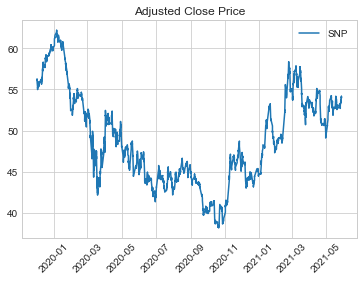

In [55]:
x = ticker_df['Date']
#y = ['Adj Close', 'Volume']
plot = plt.plot(x, ticker_df['Adj Close'])
plt.legend(plot, ['SNP'])
plt.xticks(rotation = 45)
plt.title('Adjusted Close Price')
plt.show()